In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
import plotly.express as px


2025-02-25 18:26:38.001227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'tensorflow.keras'

In [ ]:
data = np.load('cath_3class_ca.npz')

data

2025-01-26 12:57:54.130735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NpzFile 'cath_3class_ca.npz' with keys: n_atoms, atom_types, res_indices, positions, labels...

In [2]:
data.keys

<bound method Mapping.keys of NpzFile 'cath_3class_ca.npz' with keys: n_atoms, atom_types, res_indices, positions, labels...>

In [3]:
data['n_atoms'].shape

(16962,)

In [4]:
data['atom_types']

array([[b'CA', b'CA', b'CA', ..., b'', b'', b''],
       [b'CA', b'CA', b'CA', ..., b'', b'', b''],
       [b'CA', b'CA', b'CA', ..., b'', b'', b''],
       ...,
       [b'CA', b'CA', b'CA', ..., b'', b'', b''],
       [b'CA', b'CA', b'CA', ..., b'', b'', b''],
       [b'CA', b'CA', b'CA', ..., b'', b'', b'']], dtype='|S10')

In [5]:
data['split_start_indices']

array([    0,  1696,  3392,  5088,  6784,  8480, 10176, 11872, 13568,
       15265])

In [27]:
data['n_atoms'][0]

176

In [7]:
data['positions'].shape

(16962, 1202, 3)

In [8]:
np.unique(data['atom_types'])

array([b'', b'CA'], dtype='|S10')

In [9]:
np.unique(data['labels'])

array([1, 2, 3])

In [18]:
data['labels'][-1]

array([3])

In [ ]:


class_types_str = ['Mainly Alpha', 'Mainly Beta', 'Alpha-Beta']


protein_num = 15961
class_type_int = data['labels'][protein_num][0] - 1
fig = px.scatter_3d(
    x=data['positions'][protein_num, :, 0],
    y=data['positions'][protein_num, :, 1],
    z=data['positions'][protein_num, :, 2],
)

fig.update_layout(
    title=f"3D Structure of Protein #{protein_num} of Class: '{class_types_str[class_type_int]}'",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()


In [12]:
tensor_positions = tf.convert_to_tensor(data['positions'])
tensor_lables = tf.convert_to_tensor(data['labels'])

2025-01-21 19:01:54.294121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
tensor_positions

<tf.Tensor: shape=(16962, 1202, 3), dtype=float64, numpy=
array([[[ -0.46251011,  14.0216713 ,  -0.11604881],
        [  2.52248955,  14.92267227,   2.01995087],
        [  0.57148933,  16.07967186,   5.23795128],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[ -6.64554596,  -5.63561249,  18.64831161],
        [-10.16054726,  -6.35861206,  17.29231262],
        [-12.48954582,  -8.9446106 ,  15.77331161],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[-16.6552372 ,   7.00945473,  -6.4570446 ],
        [-14.97323608,   8.41845512,  -3.35804367],
        [-11.21023655,   7.94345474,  -3.03304291],
        ...,
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.  

In [14]:
tensor_positions = tf.convert_to_tensor(data['positions'], dtype=tf.float32)
tensor_labels = tf.convert_to_tensor(data['labels'], dtype=tf.int32)

tensor_labels = tf.keras.utils.to_categorical(tensor_labels - 1, num_classes=3) 
train_size = int(0.8 * tensor_positions.shape[0])
train_positions = tensor_positions[:train_size]
train_labels = tensor_labels[:train_size]
val_positions = tensor_positions[train_size:]
val_labels = tensor_labels[train_size:]

model = keras.Sequential([
    layers.Input(shape=(1202, 3)),  
    layers.Flatten(),                 
    layers.Dense(128, activation='relu'),  
    layers.Dense(64, activation='relu'),  
    layers.Dense(3, activation='softmax')   
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # use categorical crossentropy for multi-class classification
              metrics=['accuracy'])


model.summary()

history = model.fit(train_positions, train_labels,
                    validation_data=(val_positions, val_labels),
                    epochs=20,               
                    batch_size=32)          

val_loss, val_accuracy = model.evaluate(val_positions, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3606)              0         
                                                                 
 dense (Dense)               (None, 128)               461696    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 470,147
Trainable params: 470,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
425/425 [==============================] - 1s 3ms/step - loss: 1.4113 - accuracy: 0.4756 - val_loss: 1.1209 - val_accuracy: 0.5108
Epoch 2/20
425/425 [====================

KeyboardInterrupt: 

# 3d Convolutional Neural Network

In [14]:
 import tensorflow as tf
from tensorflow.keras import layers, models

# Reshape positions tensor for 3D CNN input
tensor_positions = tf.convert_to_tensor(data['positions'], dtype=tf.float32)
tensor_positions = tf.expand_dims(tensor_positions, axis=-1)  # Add a channel dimension
tensor_positions = tf.expand_dims(tensor_positions, axis=2)   # Add a spatial dimension for 3D convolution

tensor_labels = tf.convert_to_tensor(data['labels'], dtype=tf.int32)
tensor_labels = tf.keras.utils.to_categorical(tensor_labels - 1, num_classes=3)

# Split data into training and validation sets
train_size = int(0.8 * tensor_positions.shape[0])
train_positions = tensor_positions[:train_size]
train_labels = tensor_labels[:train_size]
val_positions = tensor_positions[train_size:]
val_labels = tensor_labels[train_size:]

# Build 3D CNN model
model = models.Sequential([
    layers.Input(shape=(1202, 1, 3, 1)),  # Input shape for 3D CNN
    layers.Conv3D(filters=32, kernel_size=(3, 1, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),  # Pooling size adjusted
    layers.Conv3D(filters=64, kernel_size=(3, 1, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),  # Pooling size adjusted
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(train_positions, train_labels,
                    validation_data=(val_positions, val_labels),
                    epochs=20,
                    batch_size=32)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_positions, val_labels)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 1202, 1, 3, 32) │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 601, 1, 3, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 601, 1, 3, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 301, 1, 3, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57792)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     7,397,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,424,771 (28.32 MB)

 Trainable params: 7,424,771 (28.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 71s 166ms/step - accuracy: 0.5404 - loss: 0.9413 - val_accuracy: 0.6879 - val_loss: 0.7178
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 70s 165ms/step - accuracy: 0.8449 - loss: 0.3714 - val_accuracy: 0.8963 - val_loss: 0.2903
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - accuracy: 0.8929 - loss: 0.2742 - val_accuracy: 0.8809 - val_loss: 0.3031
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.9144 - loss: 0.2178 - val_accuracy: 0.8889 - val_loss: 0.3066
Epoch 5/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 71s 167ms/step - accuracy: 0.9397 - loss: 0.1633 - val_accuracy: 0.8715 - val_loss: 0.4066
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 71s 167ms/step - accuracy: 0.9571 - loss: 0.1132 - val_accuracy: 0.8317 - val_loss: 0.5522
Epoch 7/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 71s 167ms/step - accuracy: 0.9661 - loss: 0.0908 - val_accuracy: 0.8680 - val_loss: 0.4858
Epoch 8/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 72s 170ms/step - accuracy: 0.9798 - loss: 0

In [15]:
import matplotlib.pyplot as plt
from keras.src.callbacks.history import History

def plot_results(history: History):
    """
    Plots model accuracy vs epoch AND model loss vs epoch (for train and validation data).
    Args:
        history (Keras History Object): this is the Keras's History object returned when running model.fit()
    Returns:
        None 
    """
    # training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    # training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss vs Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

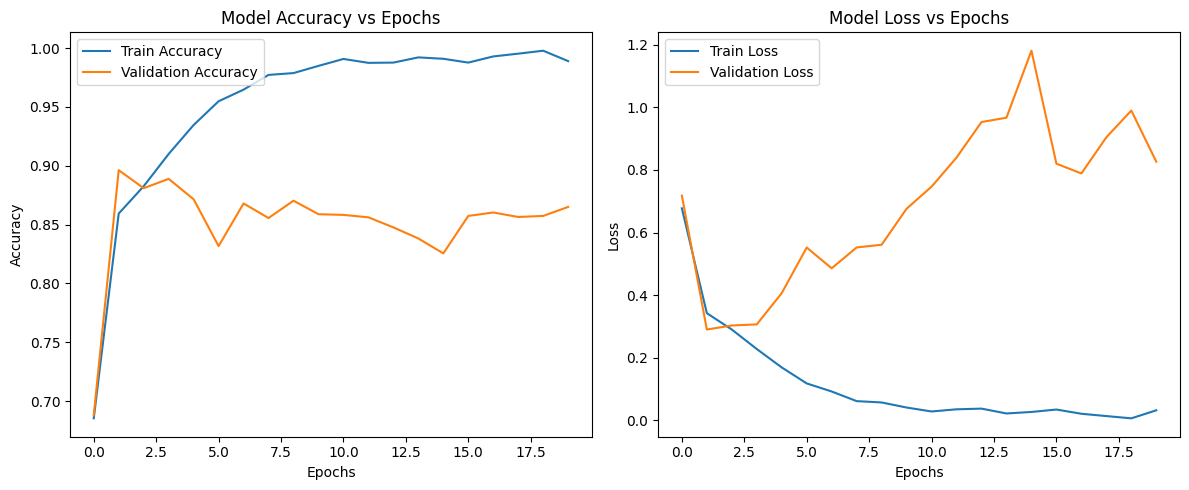

In [16]:
plot_results(history)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import KFold

# Reshape positions tensor for 3D CNN input
tensor_positions = tf.convert_to_tensor(data['positions'], dtype=tf.float32)
tensor_positions = tf.expand_dims(tensor_positions, axis=-1)
tensor_positions = tf.expand_dims(tensor_positions, axis=2)

tensor_labels = tf.convert_to_tensor(data['labels'], dtype=tf.int32)
tensor_labels = tf.keras.utils.to_categorical(tensor_labels - 1, num_classes=3)

# Get split indices
split_indices = data['split_start_indices']

# Define the model architecture
def create_model():
    model = models.Sequential([
        layers.Input(shape=(1202, 1, 3, 1)),
        layers.Conv3D(filters=32, kernel_size=(3, 1, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),
        layers.Conv3D(filters=64, kernel_size=(3, 1, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(2, 1, 1), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Perform 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=False)
cv_scores = []

for fold, (train_index, val_index) in enumerate(kfold.split(tensor_positions)):
    print(f"Fold {fold + 1}")
    
    # Use the provided split indices
    train_start_ind = split_indices[fold]
    train_end_ind = split_indices[fold + 1]


    if fold < 8:
        # use the next sequential kfold set as the validation set
        val_start_ind = split_indices[fold + 1] if fold < 9 else len(tensor_positions)
        val_end_ind = split_indices[fold + 2]

        val_positions = tensor_positions[val_start_ind:val_end_ind] 
        val_labels = tensor_labels[val_start_ind:val_end_ind] 
    else:
        # cycle back for folds 9 and 10
        test_start_ind = split_indices[fold]
        tests_end_ind = split_indices[fold]

        test_positions = tensor_positions[test_start_ind:tests_end_ind]
        test_labels = tensor_labels[test_start_ind:tests_end_ind]
        
        break

    print(f'Train index start: {train_start_ind}')
    print(f'Train index end: {train_end_ind}') # this should be the same as val_start_ind
    print(f'Val index start: {val_start_ind}') # this should be the same as train_end_ind
    print(f'Val index end: {val_end_ind}')
    
    train_positions = tensor_positions[train_start_ind:val_start_ind]
    train_labels = tensor_labels[train_start_ind:val_start_ind]

    print(f'Train data shape{ {train_positions.shape}}')
    print(f'Train labels shape{ {train_labels.shape}}')
    
    print(f'Val data shape{ {val_positions.shape}}')
    print(f'Val labels shape{ {val_labels.shape}}')

    model = create_model()

    history = model.fit(train_positions, train_labels,
                        validation_data=(val_positions, val_labels),
                        epochs=8,
                        batch_size=32,
                        verbose=1)
    
    val_loss, val_accuracy = model.evaluate(val_positions, val_labels, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    cv_scores.append(val_accuracy)

print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


Fold 1
Train index start: 0
Train index end: 1696
Val index start: 1696
Val index end: 3392
Train data shape{TensorShape([1696, 1202, 1, 3, 1])}
Train labels shape{TensorShape([1696, 3])}
Val data shape{TensorShape([1696, 1202, 1, 3, 1])}
Val labels shape{TensorShape([1696, 3])}
Epoch 1/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.3812 - loss: 1.4356 - val_accuracy: 0.3980 - val_loss: 1.0931
Epoch 2/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.5237 - loss: 0.9776 - val_accuracy: 0.5607 - val_loss: 0.9484
Epoch 3/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.7612 - loss: 0.5775 - val_accuracy: 0.6120 - val_loss: 0.7884
Epoch 4/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.8474 - loss: 0.3931 - val_accuracy: 0.6680 - val_loss: 0.9180
Epoch 5/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9455 - loss: 0.1630 - val_accuracy: 0.6616 - val_loss: 1.0537
Epoch 6/8
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9779 - loss: 0

2025-01-21 17:49:48.527720: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [64,3]
	 [[{{function_node __inference_one_step_on_data_286384}}{{node adam/truediv_17}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_17 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/2x/ff9c3jq93jd0gvcs_p8fh_f00000gn/T/ipykernel_37125/2725635115.py", line 78, in <module>

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 80, in train_step

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 383, in apply_gradients

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 448, in apply

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 511, in _backend_apply_gradients

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 120, in _backend_update_step

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 134, in _distributed_tf_update_step

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 131, in apply_grad_to_update_var

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 6055, in divide

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Users/jairusmartinez/Library/CloudStorage/OneDrive-UniversityofDenver/UniversityOfDenver/COMP4531/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2398, in divide

Incompatible shapes: [0] vs. [64,3]
	 [[{{node adam/truediv_17}}]] [Op:__inference_multi_step_on_iterator_286461]

In [18]:
val_labels.shape

TensorShape([1697, 3])

In [19]:
val_labels

<tf.Tensor: shape=(1697, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>